Что день грядущий нам готовит? Построение прогноза временного ряда с использованием изученных методов.
Цель: В этом домашнем задании будет заниматься очень интересными прогнозами, которые вполне могут быть полезны для организации работы метро - попробуем построить модель, которая предсказывает, сколько пассажиров будут им пользоваться в ближайшее время. 
Подготовка

1. Скачиваем данные по загруженности метро вот отсюда https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume
2. Проводим базовый EDA, вам понадобятся только 4 столбца датасета - traffic_volume (наша целевая переменная), date_time, holiday (является ли день некоторым праздником) и temp (температура воздуха)
3. По результатам EDA убеждаемся, что в этом временном ряду во-первых, есть дубликаты, а во-вторых, нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час - дубликаты удаляем, а временные интервалы выравниваем и заполняем пропуски при помощи линейной интерполяции (подсказка - в этом вам помогут функции pd.date_range, и interpolate, пример можно найти здесь - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html) 

Моделирование

Теперь, когда ряд выглядит более-менее адекватно, настало время прогнозировать. Нашей целью будет построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю (т.е, так как данные у нас дневные, модель должна предсказывать на 24*7 точек вперёд). 
1. Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек
2. Теперь у вас осталось еще много-много наблюдений во временном ряду, исходя из графиков, трендов и т.д., попробуйте предположить, какие исторические данные действительно будут релевантны для прогнозов текущих значений, возможно, предыдущие три года уже не так сильно влияют на следующую неделю и можно значительную часть данных просто выкинуть
3. Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня
4. Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели, посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() и используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными
5. А теперь свободное творчество - попробуйте построить разные модели, которые мы с вами разбирали, и побить качество базового прогноза. 

Несколько советов 
- для SARIMA модели имеет смысл указать недельную сезонность (т.е. 24*7), чтобы она учла падения по выходным
- попробуйте использовать температуру воздуха, как признак, в этом случае можно отдельно спрогнозировать температуру (например, используя SARIMA), а затем воспользоваться этими предсказаниями, когда будете делать прогноз для отложенной части выборки

6. Наконец, когда вы подберете модель, устраивающую вас по качеству на отложенной выборке, используйте эту выборку для построения прогноза на следующую неделю и попробуйте построить доверительные интервалы для этого прогноза
7. Теперь вы круто разбираетесь в прогнозировании и временных рядах :) 


In [54]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook


from pmdarima import auto_arima

from fbprophet import Prophet
%matplotlib inline

In [2]:
# data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv',index_col=['date_time'], parse_dates=['date_time'],usecols=["traffic_volume", "temp", "holiday",'date_time'])
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv',usecols=["date_time","traffic_volume", "temp", "holiday"])


In [3]:
data

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516
2,None,289.58,2012-10-02 11:00:00,4767
3,None,290.13,2012-10-02 12:00:00,5026
4,None,291.14,2012-10-02 13:00:00,4918
...,...,...,...,...
48199,None,283.45,2018-09-30 19:00:00,3543
48200,None,282.76,2018-09-30 20:00:00,2781
48201,None,282.73,2018-09-30 21:00:00,2159
48202,None,282.09,2018-09-30 22:00:00,1450


## EDA

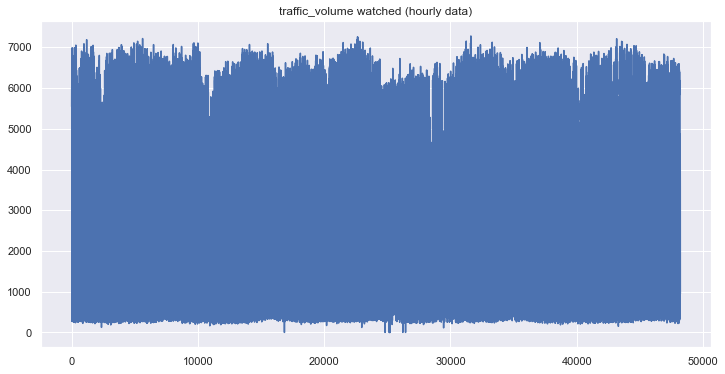

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(data.traffic_volume)
plt.title('traffic_volume watched (hourly data)')
plt.grid(True)
plt.show()

Красивый, но довольно таки бесполезный график. Поэтому просто понастальгируем по винампу

In [5]:
data.shape

(48204, 4)

In [6]:
data.count()


holiday           48204
temp              48204
date_time         48204
traffic_volume    48204
dtype: int64

Посмотрим что по дубликатам

In [7]:
duplicate_rows_df = data[data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (7551, 4)


In [8]:
duplicate_rows_df

,holiday,temp,date_time,traffic_volume
179,None,281.25,2012-10-10 07:00:00,6793
181,None,280.10,2012-10-10 08:00:00,6283
183,None,279.61,2012-10-10 09:00:00,5680
270,None,282.43,2012-10-14 09:00:00,2685
271,None,282.43,2012-10-14 09:00:00,2685
...,...,...,...,...
48072,None,284.25,2018-09-25 16:00:00,6597
48112,None,285.17,2018-09-27 07:00:00,6589
48173,None,280.68,2018-09-29 19:00:00,3818
48193,None,283.48,2018-09-30 14:00:00,4380


In [9]:
data=data.drop_duplicates(keep=False)
data

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516
2,None,289.58,2012-10-02 11:00:00,4767
3,None,290.13,2012-10-02 12:00:00,5026
4,None,291.14,2012-10-02 13:00:00,4918
...,...,...,...,...
48199,None,283.45,2018-09-30 19:00:00,3543
48200,None,282.76,2018-09-30 20:00:00,2781
48201,None,282.73,2018-09-30 21:00:00,2159
48202,None,282.09,2018-09-30 22:00:00,1450


In [10]:

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

# moving_average(data, 24) # prediction for the last observed day (past 24 hours)

In [12]:
print(data.isnull().sum())

holiday           0
temp              0
date_time         0
traffic_volume    0
dtype: int64


In [13]:
data.date_time = pd.to_datetime(data.date_time)
rng = pd.date_range(start=data.date_time.min(), end=data.date_time.max(), freq='H')

data = data.set_index('date_time')
data=pd.merge(data, pd.Series(index=rng, name='rng'), how='outer', left_index=True, right_index=True).drop('rng', 1)

In [14]:

print(data.isnull().sum())

holiday           17354
temp              17354
traffic_volume    17354
dtype: int64


Смотрим что получилось

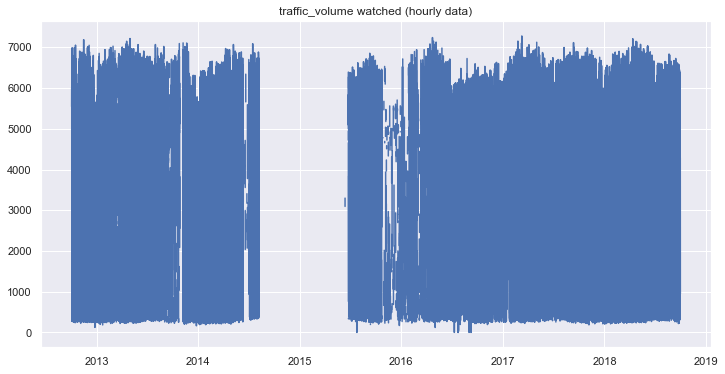

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(data.traffic_volume)
plt.title('traffic_volume watched (hourly data)')
plt.grid(True)
plt.show()

#### Делаем интерполяцию что бы заполнить пропущенные данные

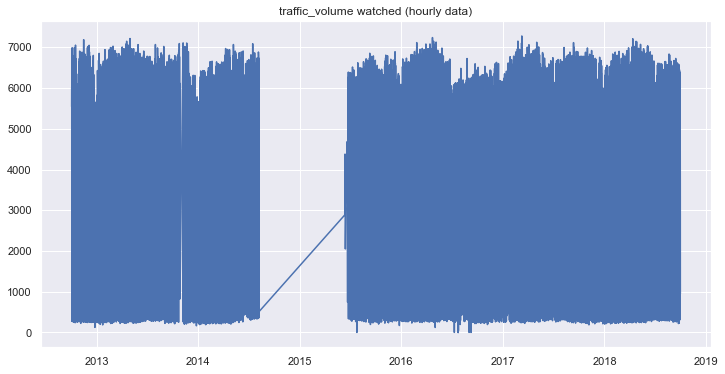

In [16]:
data_new=data.interpolate(method='linear', order=2)
plt.figure(figsize=(12, 6))
plt.plot(data_new.traffic_volume)
plt.title('traffic_volume watched (hourly data)')
plt.grid(True)
plt.show()


#### От таких данных толку нет, так что возьмем данные за последние 2 года

In [17]:
days=200 * 24
data_new=data[-days:]
data_new

,holiday,temp,traffic_volume
2018-03-15 00:00:00,None,273.29,577.0
2018-03-15 01:00:00,None,273.53,354.0
2018-03-15 02:00:00,None,272.65,259.0
2018-03-15 03:00:00,NaN,NaN,NaN
2018-03-15 04:00:00,None,271.37,910.0
...,...,...,...
2018-09-30 19:00:00,None,283.45,3543.0
2018-09-30 20:00:00,None,282.76,2781.0
2018-09-30 21:00:00,None,282.73,2159.0
2018-09-30 22:00:00,None,282.09,1450.0


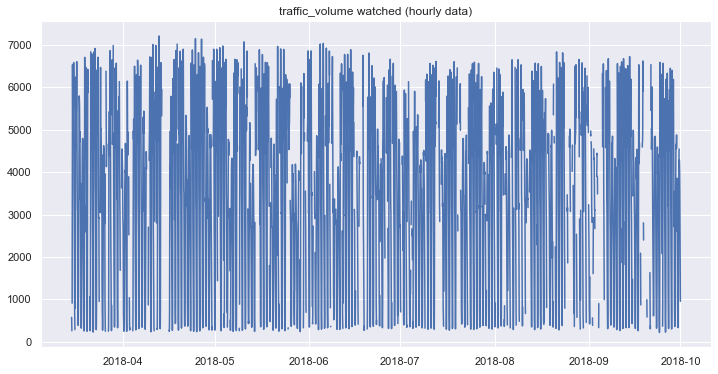

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(data_new.traffic_volume)
plt.title('traffic_volume watched (hourly data)')
plt.grid(True)
plt.show()

In [19]:
print(data_new.isnull().sum())

holiday           774
temp              774
traffic_volume    774
dtype: int64


In [20]:
data_new=data_new.interpolate(method='linear', order=2)
print(data_new.isnull().sum())

holiday           774
temp                0
traffic_volume      0
dtype: int64


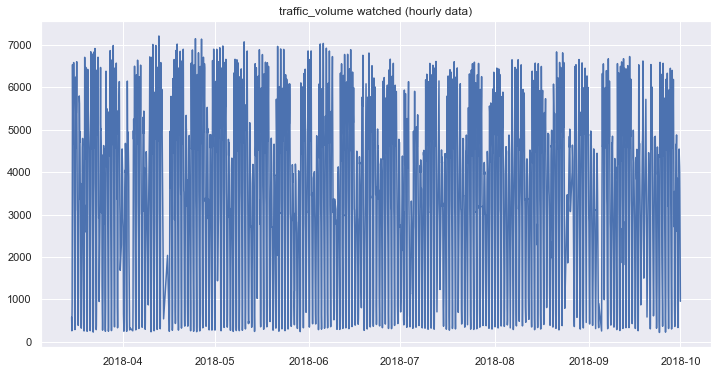

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(data_new.traffic_volume)
plt.title('traffic_volume watched (hourly data)')
plt.grid(True)
plt.show()

In [22]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(data_new['traffic_volume'], 24) 

2510.4583333333335

In [23]:
def plotMovingAverage(series, window, center=True, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        center - whether to center the window
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window, center=center).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:].fillna(0), rolling_mean[window:].fillna(0))
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

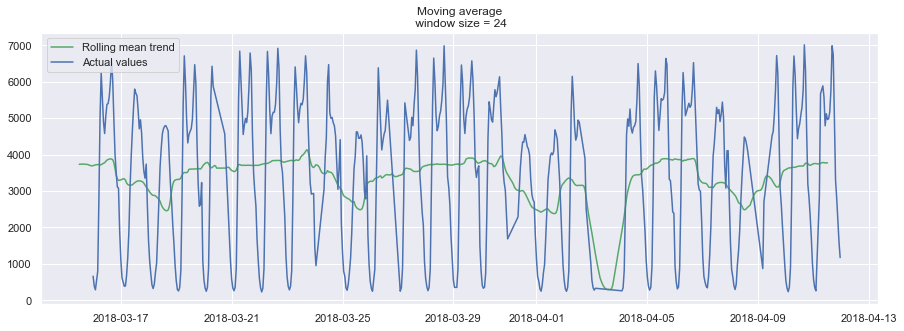

In [24]:
plotMovingAverage(data_new[:672]['traffic_volume'], 24) 

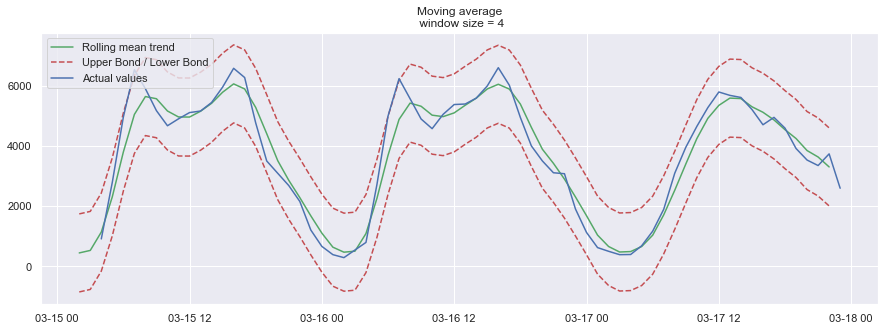

In [25]:
plotMovingAverage(data_new[:72]['traffic_volume'], 4, plot_intervals=True)

### Подготовим данные по праздникам

1. Посмотрим чем заполнены поля в столбце праздника
2. Заменим пустые на None
3. Праздник не может длиться один час, поэтому заполним весь день отметкой празника
4. Так как конкретный праздник из 17000+ строк встрется максимум 14, заменим названия на бинарный признак

In [26]:
data_new['holiday'].unique()


array(['None', nan, 'Memorial Day', 'Independence Day', 'State Fair'],
      dtype=object)

In [27]:
data_new=data_new.fillna('None')
data_new['holiday'].unique()
# data_new[(data_new['holiday']!='None') ]

array(['None', 'Memorial Day', 'Independence Day', 'State Fair'],
      dtype=object)

In [28]:
for index, row in data_new[(data_new['holiday']!='None') ].iterrows():
    value=str(index).replace(" 00:00:00","")
    print(value, row['holiday'])
    data_new[value:value]['holiday']=row['holiday']
#     print(str(index).replace(" 00:00:00",""))

2018-05-28 Memorial Day
2018-07-04 Independence Day
2018-08-23 State Fair


In [29]:
data_new['holiday'] = data_new['holiday'].apply(lambda X : 0 if X == 'None' else 1)

In [30]:
#data.index = pd.to_datetime(data.index)
#data["hour"] = data.index.hour
#data["weekday"] = data.index.weekday
#data['is_weekend'] = data.weekday.isin([5,6])*1
#data.tail()

In [31]:
data_new.index = pd.to_datetime(data_new.index, format="%Y-%m-%d %H:%M:%S")
data_new["month"] = data_new.index.month
data_new["day"] = data_new.index.day
data_new["hour"] = data_new.index.hour
data_new["day_of_week"] = data_new.index.dayofweek
data_new

,holiday,temp,traffic_volume,month,day,hour,day_of_week
2018-03-15 00:00:00,0,273.29,577.0,3,15,0,3
2018-03-15 01:00:00,0,273.53,354.0,3,15,1,3
2018-03-15 02:00:00,0,272.65,259.0,3,15,2,3
2018-03-15 03:00:00,0,272.01,584.5,3,15,3,3
2018-03-15 04:00:00,0,271.37,910.0,3,15,4,3
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,0,283.45,3543.0,9,30,19,6
2018-09-30 20:00:00,0,282.76,2781.0,9,30,20,6
2018-09-30 21:00:00,0,282.73,2159.0,9,30,21,6
2018-09-30 22:00:00,0,282.09,1450.0,9,30,22,6


In [32]:
for i in range(6, 25):
    data_new["lag_{}".format(i)] = data_new.traffic_volume.shift(i)
data_new=data_new.dropna()

## МОДЕЛИРОВАНИЕ

In [33]:
data_models=data_new.copy()


In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [35]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [36]:
y = data_models.dropna().traffic_volume
X = data_models.dropna().drop(['traffic_volume'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [38]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

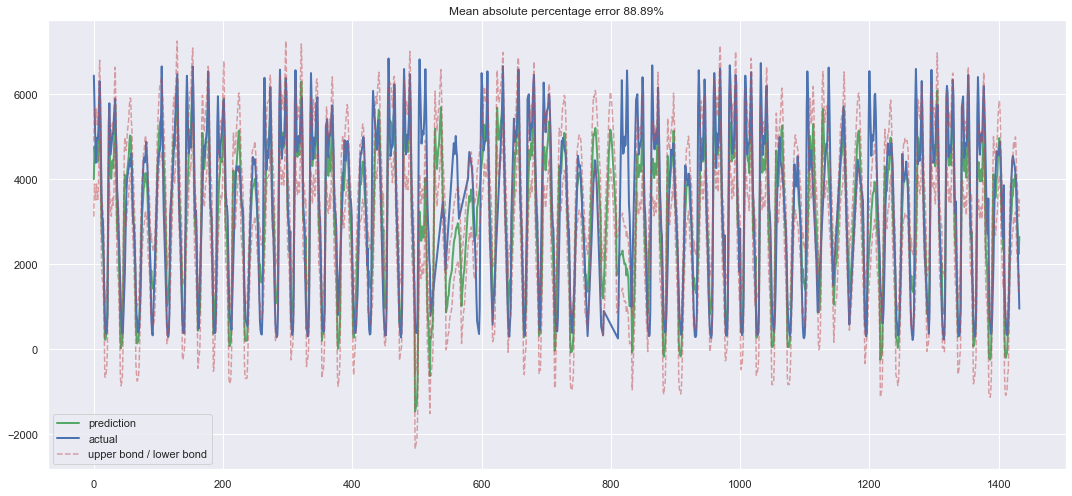

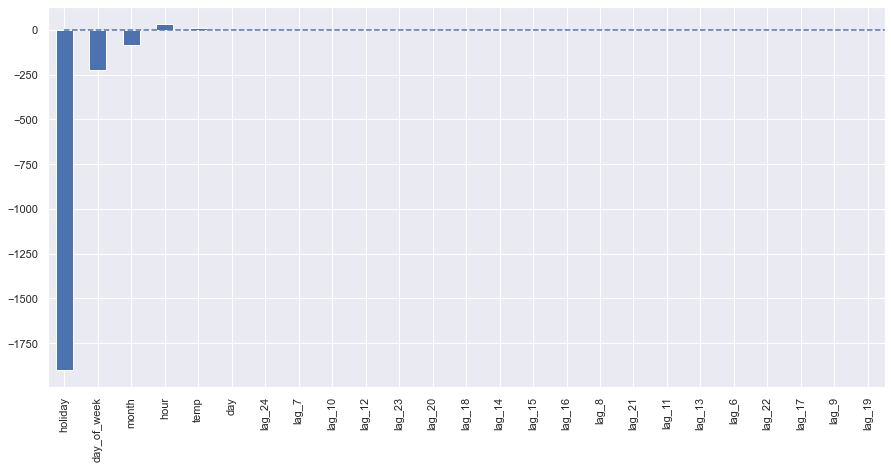

In [39]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

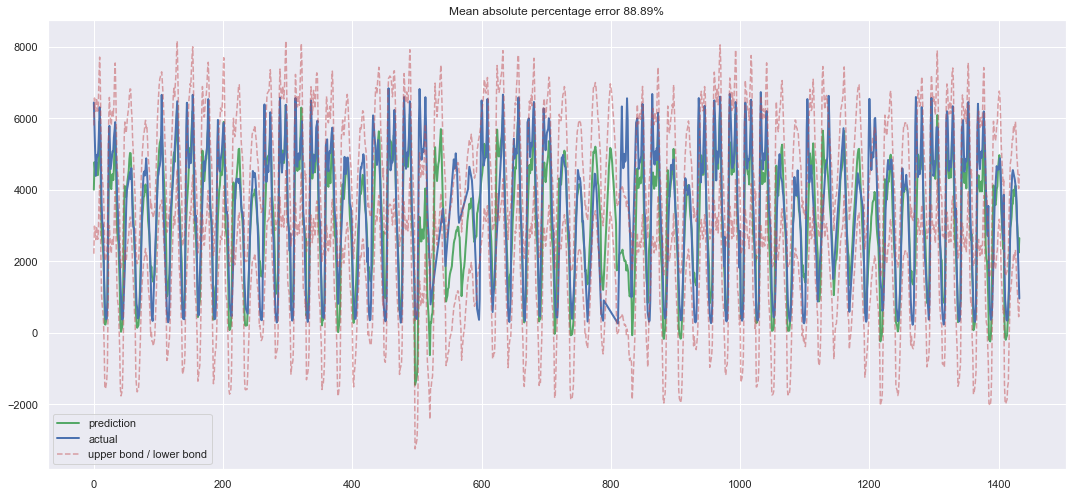

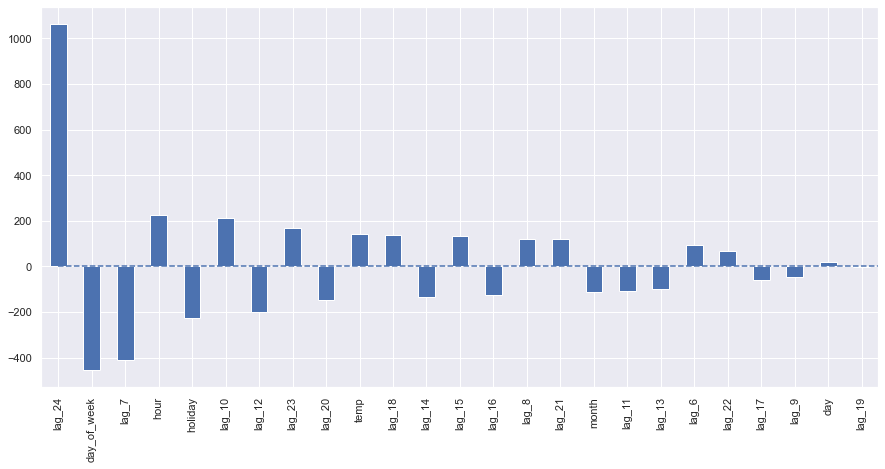

In [41]:
y = data_models.dropna().traffic_volume
X = data_models.dropna().drop(['traffic_volume'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [42]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

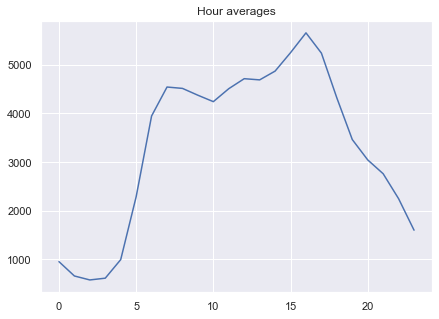

In [43]:
average_hour = code_mean(data_models, 'hour', "traffic_volume")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

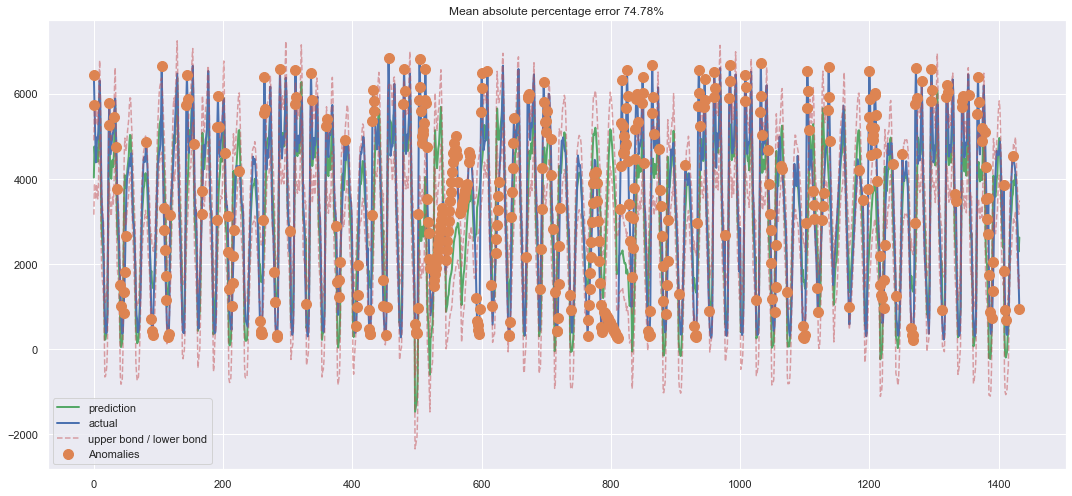

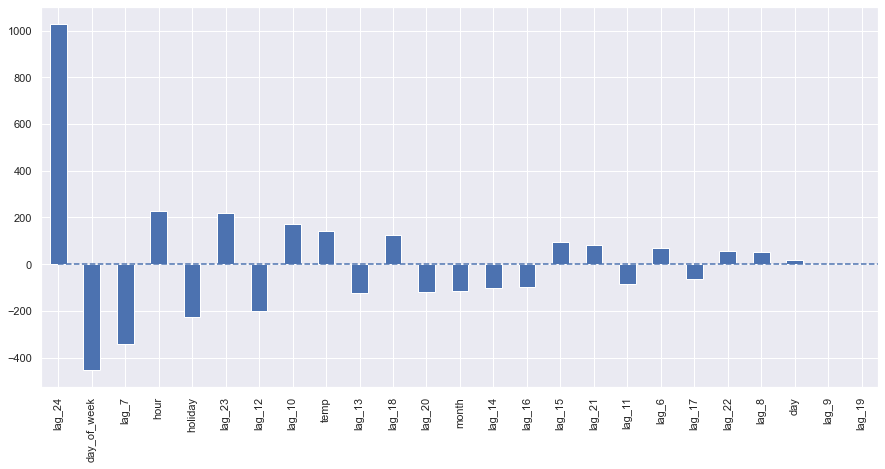

In [44]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

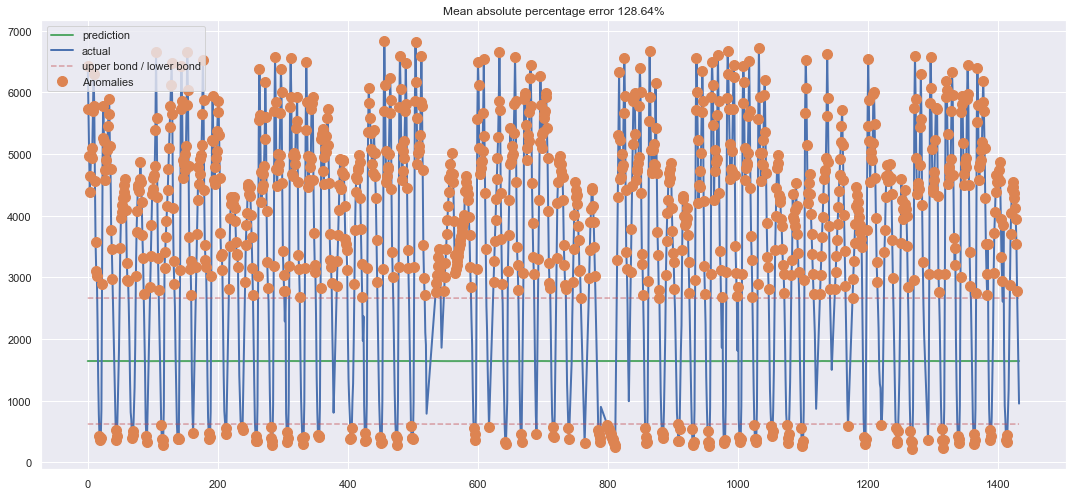

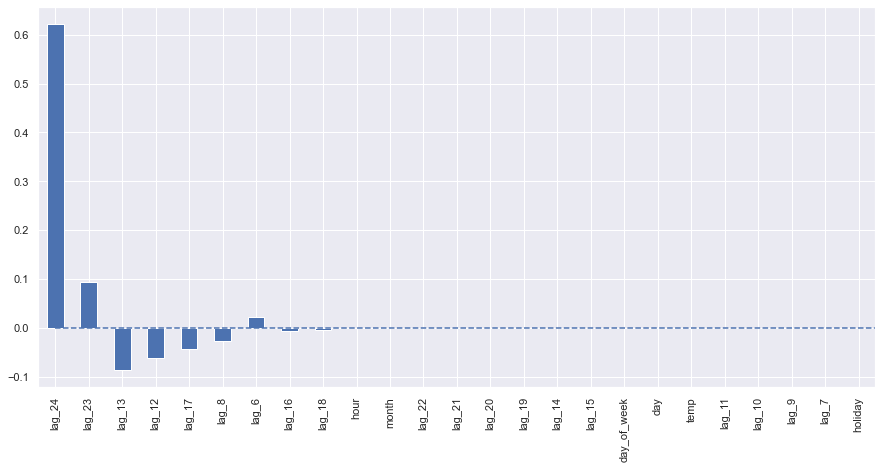

In [45]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

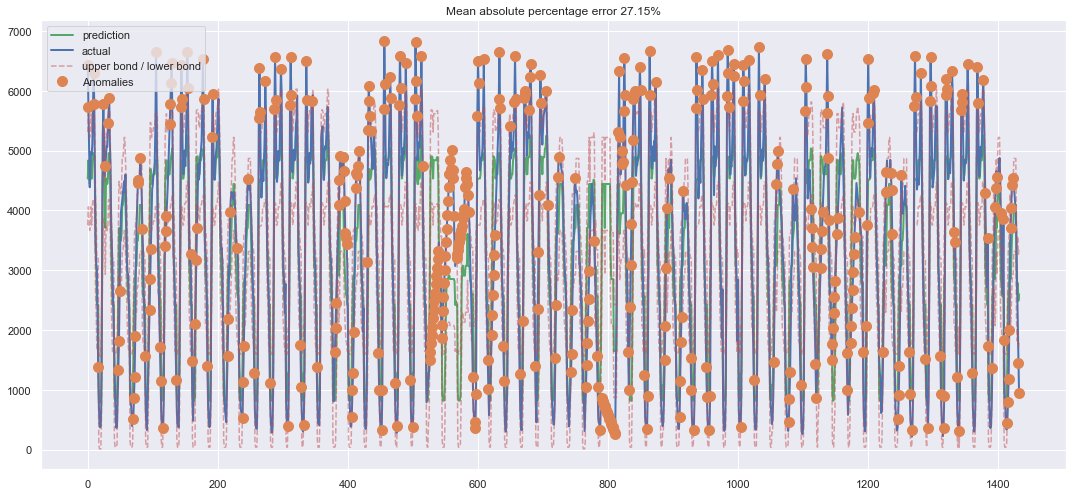

In [46]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

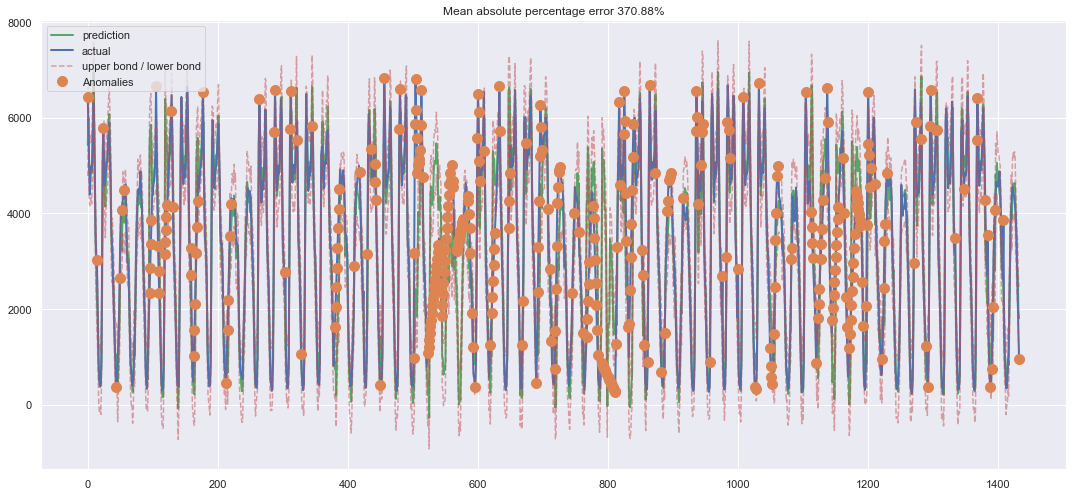

In [47]:
from catboost import CatBoostRegressor


catboost = CatBoostRegressor(iterations=100, learning_rate=0.7,
                          loss_function='RMSE', verbose=0)

catboost.fit(X_train_scaled, y_train, verbose=0)

plotModelResults(catboost, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

#### Самые хорошие результаты показал AdaBoostRegressor

### Попробуем повторить все на готовых библиотеках

### ARIMAX

In [48]:
data_new['Date']=data_new.index
df_train = data_new[:-24*14]
df_valid = data_new[-24*14:]
exogenous_features = data_new.drop(['traffic_volume','Date'],axis=1).columns


In [49]:
# data_new=data_new.dropna()

# df_train = data_new[:-24*14]
# df_valid = data_new[-24*14:]

# exogenous_features = data_new.drop(['traffic_volume','Date'],axis=1).columns
# exogenous_features

model = auto_arima(df_train.traffic_volume, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.traffic_volume, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=66810.869, Time=18.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=74082.390, Time=1.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=67782.989, Time=10.50 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=70528.814, Time=14.70 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=97802.872, Time=9.46 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=66791.211, Time=15.53 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=68545.782, Time=15.93 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=66861.211, Time=14.72 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=66769.426, Time=16.26 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=67425.515, Time=16.65 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=66765.766, Time=17.59 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=66745.043, Time=18.47 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=66696.171, Time=17.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=66615.874, Time=16.91 sec
 ARIMA(

In [50]:
print("RMSE of Forecast_ARIMAX:", np.sqrt(mean_squared_error(df_valid.traffic_volume, df_valid.Forecast_ARIMAX)))
print("MAE of Forecast_ARIMAX:", mean_absolute_error(df_valid.traffic_volume, df_valid.Forecast_ARIMAX))
print("MAPE of Forecast_ARIMAX:", mean_absolute_percentage_error(df_valid.traffic_volume, df_valid.Forecast_ARIMAX))

RMSE of Forecast_ARIMAX: 980.7236882452557
MAE of Forecast_ARIMAX: 744.7714684022283
MAPE of Forecast_ARIMAX: 47.37296147956781


In [51]:
X_train_scaled = scaler.fit_transform(df_train[exogenous_features])
X_test_scaled = scaler.transform(df_valid[exogenous_features])
model = auto_arima(df_train.traffic_volume, exogenous=X_train_scaled, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.traffic_volume, exogenous=X_train_scaled)

forecast = model.predict(n_periods=len(df_valid), exogenous=X_test_scaled)
df_valid["Forecast_ARIMAX_scaled"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=66821.934, Time=16.89 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=74081.653, Time=0.42 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=67655.739, Time=10.60 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=69913.946, Time=13.78 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=117928.624, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=66729.060, Time=15.22 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=68040.139, Time=15.46 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=67033.112, Time=14.20 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=66743.999, Time=16.81 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=67128.649, Time=15.62 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=66808.117, Time=15.51 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=66854.584, Time=16.71 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=67376.640, Time=16.94 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 168.533 sec

In [52]:
print("RMSE of Forecast_ARIMAX_scaled:", np.sqrt(mean_squared_error(df_valid.traffic_volume, df_valid.Forecast_ARIMAX_scaled)))
print("MAE of Forecast_ARIMAX_scaled:", mean_absolute_error(df_valid.traffic_volume, df_valid.Forecast_ARIMAX_scaled))
print("MAPE of Forecast_ARIMAX_scaled:", mean_absolute_percentage_error(df_valid.traffic_volume, df_valid.Forecast_ARIMAX_scaled))

RMSE of Forecast_ARIMAX_scaled: 992.5433859711167
MAE of Forecast_ARIMAX_scaled: 721.8384563873965
MAPE of Forecast_ARIMAX_scaled: 50.510715857907286


### Prophet

In [55]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)
# print( ["Date", "traffic_volume"] + exogenous_features.tolist())

model_fbp.fit(df_train[["Date", "traffic_volume"] + exogenous_features.tolist()].rename(columns={"Date": "ds", "traffic_volume": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "traffic_volume"] + exogenous_features.tolist()].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


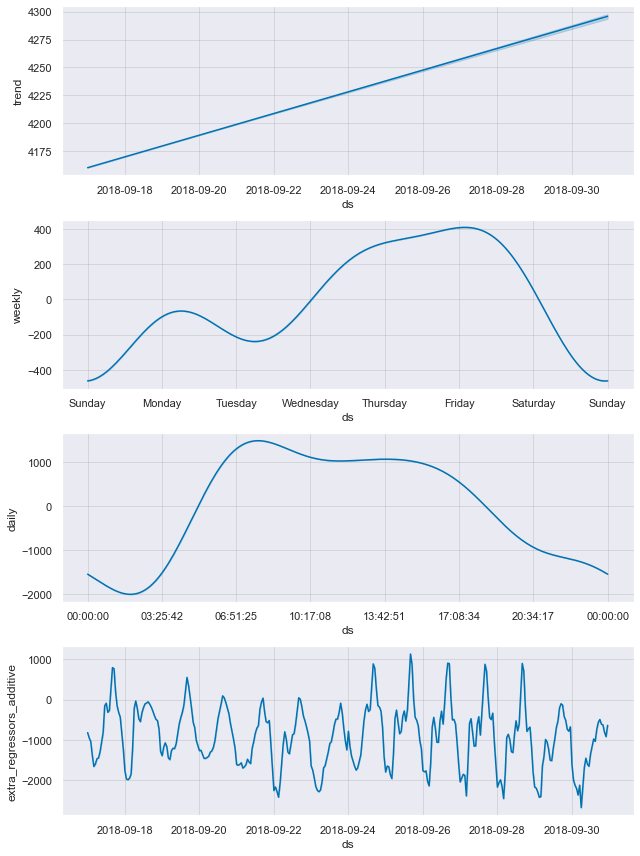

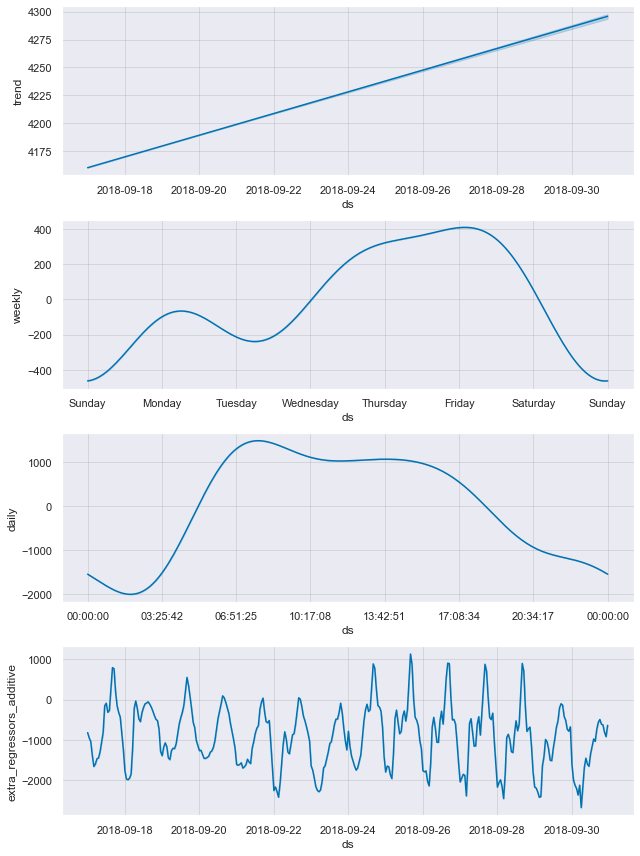

In [56]:
model_fbp.plot_components(forecast)


In [57]:
print("RMSE of Forecast_Prophet:", np.sqrt(mean_squared_error(df_valid.traffic_volume, df_valid.Forecast_Prophet)))
print("MAE of Forecast_Prophet:", mean_absolute_error(df_valid.traffic_volume, df_valid.Forecast_Prophet))
print("MAPE of Forecast_Prophet:", mean_absolute_percentage_error(df_valid.traffic_volume, df_valid.Forecast_Prophet))

RMSE of Forecast_Prophet: 853.5706715140952
MAE of Forecast_Prophet: 647.8942374331865
MAPE of Forecast_Prophet: 38.865299622243896


In [58]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)
# print( ["Date", "traffic_volume"] + exogenous_features.tolist())
df_train_scaled = df_train.copy()
df_valid_scaled = df_valid.copy()
df_train_scaled[exogenous_features] = scaler.fit_transform(df_train[exogenous_features])
df_valid_scaled[exogenous_features] = scaler.transform(df_valid[exogenous_features])

model_fbp.fit(df_train_scaled[["Date", "traffic_volume"] + exogenous_features.tolist()].rename(columns={"Date": "ds", "traffic_volume": "y"}))

forecast = model_fbp.predict(df_valid_scaled[["Date", "traffic_volume"] + exogenous_features.tolist()].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet_scaled"] = forecast.yhat.values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [59]:
print("RMSE of Forecast_Prophet_scaled:", np.sqrt(mean_squared_error(df_valid.traffic_volume, df_valid.Forecast_Prophet_scaled)))
print("MAE of Forecast_Prophet_scaled:", mean_absolute_error(df_valid.traffic_volume, df_valid.Forecast_Prophet_scaled))
print("MAPE of Forecast_Prophet_scaled:", mean_absolute_percentage_error(df_valid.traffic_volume, df_valid.Forecast_Prophet_scaled))

RMSE of Forecast_Prophet_scaled: 853.461811259509
MAE of Forecast_Prophet_scaled: 647.6905073186367
MAPE of Forecast_Prophet_scaled: 38.85455215351497


### LightGBM

In [60]:
import lightgbm as lgb

In [61]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.traffic_volume.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast

In [62]:
print("RMSE of Forecast_LightGBM:", np.sqrt(mean_squared_error(df_valid.traffic_volume, df_valid.Forecast_LightGBM)))
print("MAE of Forecast_LightGBM:", mean_absolute_error(df_valid.traffic_volume, df_valid.Forecast_LightGBM))
print("MAPE of Forecast_LightGBM:", mean_absolute_percentage_error(df_valid.traffic_volume, df_valid.Forecast_LightGBM))

RMSE of Forecast_LightGBM: 642.118112018054
MAE of Forecast_LightGBM: 436.31307575101016
MAPE of Forecast_LightGBM: 26.257629717082153


<AxesSubplot:>

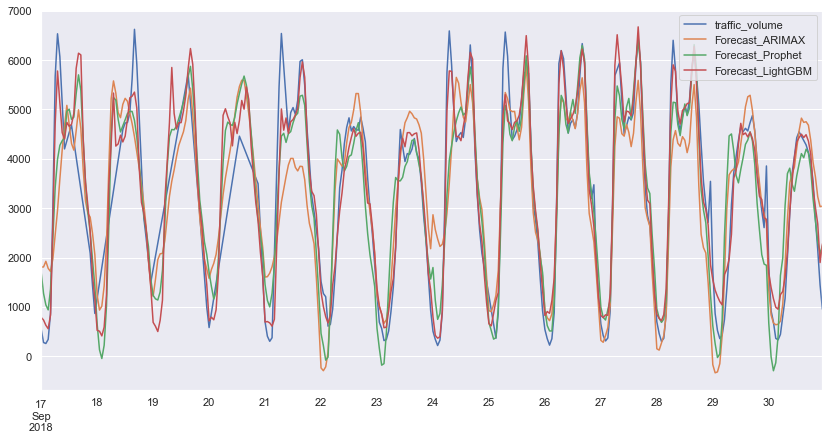

In [63]:
df_valid[["traffic_volume", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

### Остановимся на моделе LightGBM

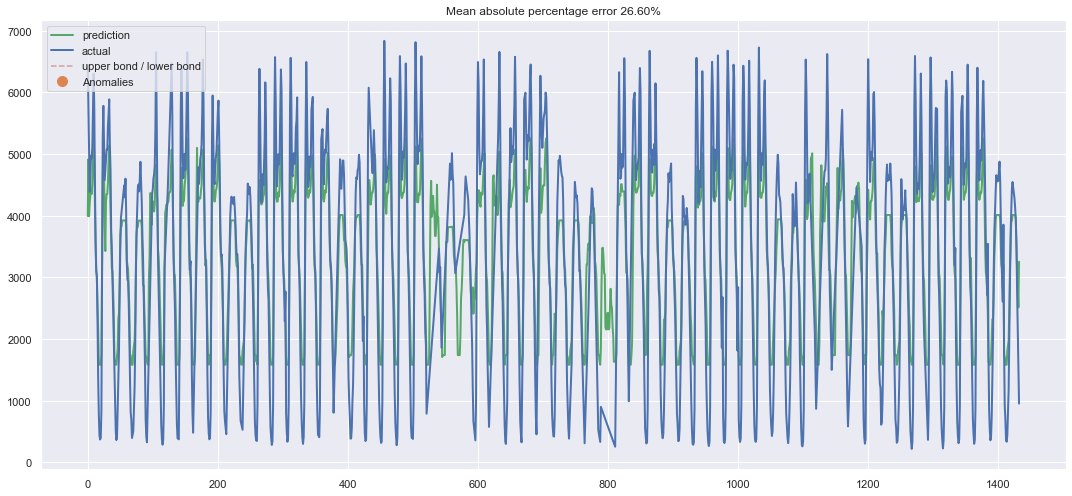

In [72]:
prediction = model_lgb.predict(X_test, num_iteration=10)
    
plt.figure(figsize=(15, 7))
plt.plot(prediction, "g", label="prediction", linewidth=2.0)
plt.plot(y_test.values, label="actual", linewidth=2.0)

if True:
    cv = cross_val_score(model, X_train, y_train, 
                                cv=tscv, 
                                scoring="neg_mean_absolute_error")
    mae = cv.mean() * (-1)
    deviation = cv.std()

    scale = 1.96
    lower = prediction - (mae + scale * deviation)
    upper = prediction + (mae + scale * deviation)

    plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
    plt.plot(upper, "r--", alpha=0.5)

    if True:
        anomalies = np.array([np.NaN]*len(y_test))
        anomalies[y_test<lower] = y_test[y_test<lower]
        anomalies[y_test>upper] = y_test[y_test>upper]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

error = mean_absolute_percentage_error(prediction, y_test)
plt.title("Mean absolute percentage error {0:.2f}%".format(error))
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);